# OpenVINO end-to-end

This repository comes with a companion Docker image required to run this notebook. Follow the instructions on (ADD_LINK) to get your Docker image running in few simple steps.

If your environment is setup propertly, you should expect to see the OpenVINO's version after executing the cell below.

In [1]:
from openvino import inference_engine as ie

print('openvino inference engine:', ie.__version__)

openvino inference engine: 2.1.37988


## Import dependencies

In [2]:
import os
import sys
import time
import logging as log
import numpy as np
import tensorflow as tf
import cv2 as cv

# from tensorflow.gfile import GFile
from IPython.display import Image
from IPython.display import HTML
from utils import parse_od_output, draw_image
from openvino import inference_engine as ie
from openvino.inference_engine import IECore
from openvino.inference_engine import IENetwork


# path to test images
TEST_DATA_PATH = os.path.join('.','data')

print('tensorflow:', tf.__version__)
print('openvino ie:', ie.__version__)
print('numpy:', np.__version__)

tensorflow: 1.15.0
openvino ie: 2.1.37988
numpy: 1.17.0


## SSD MobileNet V2

The ssd_mobilenet_v2_coco model is a Single-Shot multibox Detection (SSD) network for object detection. The model has been trained from the Common Objects in Context (COCO) image dataset.

The model input is a blob that consists of a single image of ``1x3x300x300`` in the RGB order.

The model output is a typical vector containing the tracked object data. Note that the ``class_id`` data is now significant and should be used to determine the classification for any detected object.

Model outputs:

1. Classifier, name - detection_classes, contains predicted bounding boxes classes in range [1, 91]. The model was trained with 90 categories of objects.

2. Probability, name - detection_scores, contains probability of detected bounding boxes.

3. Detection box, name - detection_boxes, contains detection boxes coordinates in format [y_min, x_min, y_max, x_max], where (x_min, y_min) are coordinates top left corner, (x_max, y_max) are coordinates of the right bottom corner. Coordinates are rescaled to the input image size.

4. Detections number, name - num_detections, contains the number of predicted detection boxes.

### Download the model

Pull the list of all models available on the Open Model Zoo.

In [3]:
!python ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py --print_all

action-recognition-0001-decoder
action-recognition-0001-encoder
age-gender-recognition-retail-0013
asl-recognition-0003
driver-action-recognition-adas-0002-decoder
driver-action-recognition-adas-0002-encoder
emotions-recognition-retail-0003
face-detection-adas-0001
face-detection-adas-binary-0001
face-detection-retail-0004
face-detection-retail-0005
face-reidentification-retail-0095
facial-landmarks-35-adas-0002
gaze-estimation-adas-0002
handwritten-score-recognition-0003
head-pose-estimation-adas-0001
human-pose-estimation-0001
image-retrieval-0001
instance-segmentation-security-0010
instance-segmentation-security-0050
instance-segmentation-security-0083
landmarks-regression-retail-0009
license-plate-recognition-barrier-0001
pedestrian-and-vehicle-detector-adas-0001
pedestrian-detection-adas-0002
pedestrian-detection-adas-binary-0001
person-attributes-recognition-crossroad-0230
person-detection-action-recognition-0005
person-detection-action-recognition-0006
person-detection-action-re

We are interested on the ``ssd_mobilenet_v2_coco`` model.

In [4]:
!python ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py --print_all | grep ssd_mobilenet_v2_coco

ssd_mobilenet_v2_coco


Download the model under the ``./data`` folder.

In [5]:
!python ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name ssd_mobilenet_v2_coco \
--output_dir ./data

################|| Downloading models ||################

========== Downloading data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco.tar.gz
... 100%, 183521 KB, 15295 KB/s, 11 seconds passed

################|| Post-processing ||################

========== Unpacking data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco.tar.gz


### Infer SSD MobileNet V2 in TensorFlow

The downloaded model was trained in TF. Let's try to validate this model perfoming inference just using TF initially.   

![TenforFlow inference](../images/inference_tf_red_graph.png "Title")

In [6]:
# Path to the TensorFlow model
model = os.path.join('data', 
                     'public', 'ssd_mobilenet_v2_coco', 
                     'ssd_mobilenet_v2_coco_2018_03_29', 
                     'frozen_inference_graph.pb')

# SSD MobileNet v2 contains following output nodes
output_names = ['detection_classes:0','detection_scores:0', 'detection_boxes:0', 'num_detections:0']

# Create a graph
graph = tf.Graph()

# Create graph definitions
graph_def = tf.GraphDef()

# Read model to the graph definitions
with open(model, 'rb') as model_file:
    graph_def.ParseFromString(model_file.read())


with graph.as_default():
    # Import the graph definitions to TensorFlow
    tf.import_graph_def(graph_def, name='')
    # Get tensors for output nodes
    output_tensors = [graph.get_tensor_by_name(layer_name) for layer_name in output_names] 

    with tf.Session(graph=graph) as session:
        # Infer the model for random datates
        print(session.run(output_tensors, feed_dict = {'image_tensor:0' : np.random.rand(1, 300, 300, 3)}))

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32), array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],

In [7]:
# Initialize logging
log.basicConfig(format="[ %(levelname)s ] %(message)s", level=log.INFO, stream=sys.stdout)

# Define how many times we run inference to get better performance
NUM_RUNS = 1 
# Number of images for one inference
BATCH = 1

# Path to a test image
IMAGE = os.path.join(TEST_DATA_PATH, 'images', 'input', 'cats.jpg')

# Path to the downloaded TensorFlow image
SSD_ASSETS = os.path.join(TEST_DATA_PATH, 'public', 'ssd_mobilenet_v2_coco')

# Path to the downloaded frozen TensorFlow image
TF_MODEL = os.path.join(SSD_ASSETS, 'ssd_mobilenet_v2_coco_2018_03_29', 'frozen_inference_graph.pb')

# Path to the resulting TensorFlow image
TF_RESULT_IMAGE = os.path.join(TEST_DATA_PATH, 'images', 'output', 'tensorflow_output.png')

# Path to the Inference Engine FP32 model
IE_MODEL_FP32_XML = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_FP32_BIN = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.bin')

# Path to the Inference Engine INT8 model optimized with the Default algorithm
IE_MODEL_DEFAULT_INT8_XML = os.path.join(SSD_ASSETS, 'INT8', 'default', 'optimized', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_DEFAULT_INT8_BIN = os.path.join(SSD_ASSETS, 'INT8', 'default', 'optimized', 'ssd_mobilenet_v2_coco.bin')

# Path to the Inference Engine INT8 model optimized  with the AccuracyAware algorithm
IE_MODEL_AA_INT8_XML = os.path.join(SSD_ASSETS, 'INT8', 'acuracy_aware', 'optimized', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_AA_INT8_BIN = os.path.join(SSD_ASSETS, 'INT8', 'acuracy_aware', 'optimized', 'ssd_mobilenet_v2_coco.bin')

# Path to the resulting TensorFlow image
IE_RESULT_IMAGE = os.path.join(TEST_DATA_PATH, 'images', 'output', 'inference_engine_output.png')

# Path to the combination of the resulting TensorFlow and Inference Engine images
COMBO_RESULT_IMAGE = os.path.join(TEST_DATA_PATH, 'images', 'output', 'combo_output.png')

PERFORMANCE = {}

In [8]:
def read_resize_image(path_to_image: str, width: int, height: int):
    """
    Takes an image and resizes it to the given dimensions.
    """
    # Load the image 
    raw_image = cv.imread(path_to_image)
    # Return the image resized to the (width, height) format
    return cv.resize(raw_image, (width, height), interpolation=cv.INTER_NEAREST)

In [9]:
def tf_inference(graph: tf.Graph, input_data, input_name: str, outputs_names: list) -> tuple:
    """
    Returns TensorFlow model inference results.
    """
    
    log.info("Running inference with TensorFlow ...")
  
    # Get the input tensor by name
    input_tensor =  graph.get_tensor_by_name('{}:0'.format(input_name))
    
    # Fill input data
    feed_dict = {
        input_tensor: [input_data, ] 
    }

    # Collect output tensors
    output_tensors = []
    
    for output_name in outputs_names:
        tensor = graph.get_tensor_by_name('{}:0'.format(output_name))
        output_tensors.append(tensor)
    
    # Run inference and get performance
    log.info("Running tf.Session")
    with graph.as_default():
        with tf.Session(graph=graph) as session:
            inference_start = time.time()
            outputs = session.run(output_tensors, feed_dict=feed_dict)
            inference_end = time.time()
    
    # Collect inference results
    res = dict(zip(outputs_names, outputs))
    
    log.info("TensorFlow reference collected successfully")
    
    return res, inference_end - inference_start

In [10]:
def tf_main(path_to_pb_model: str, 
            path_to_original_image: str, 
            number_inference: int = 1):
    """
    Entrypoint to infer with TensorFlow.
    """
    log.info('COMMON: image preprocessing')
    
    # Size of the image is 300x300 pixels, 3 channels in the RGB format
    width = 300
    
    image_shape = (300, 300, 3)
    
    resized_image = read_resize_image(path_to_original_image, width, width)
    
    reshaped_image = np.reshape(resized_image, image_shape)
    
    log.info('Current shape: {}'.format(reshaped_image.shape))

    log.info('TENSORFLOW SPECIFIC: Loading a model with TensorFlow')
    
    graph = tf.Graph()
    
    graph_def = tf.GraphDef()

    with open(path_to_pb_model, "rb") as model_file:
        graph_def.ParseFromString(model_file.read())

    with graph.as_default():
        tf.import_graph_def(graph_def, name='')

    log.info("TensorFlow graph was created")
    
    # We use SSD MobileNet V2 and we know the name of the input 
    input_layer = 'image_tensor'
    
    # And we know names of outputs
    output_layers = ['num_detections', 'detection_classes', 'detection_scores', 'detection_boxes']
    
    collected_inference_time = []
    
    for run in range(number_inference):
        raw_results, inference_time = tf_inference(graph, reshaped_image, input_layer, output_layers)
        collected_inference_time.append(inference_time)
    
    tensorflow_average_inference_time = sum(collected_inference_time) / number_inference
    
    log.info('TENSORFLOW SPECIFIC: Plain inference finished')

    return raw_results, tensorflow_average_inference_time

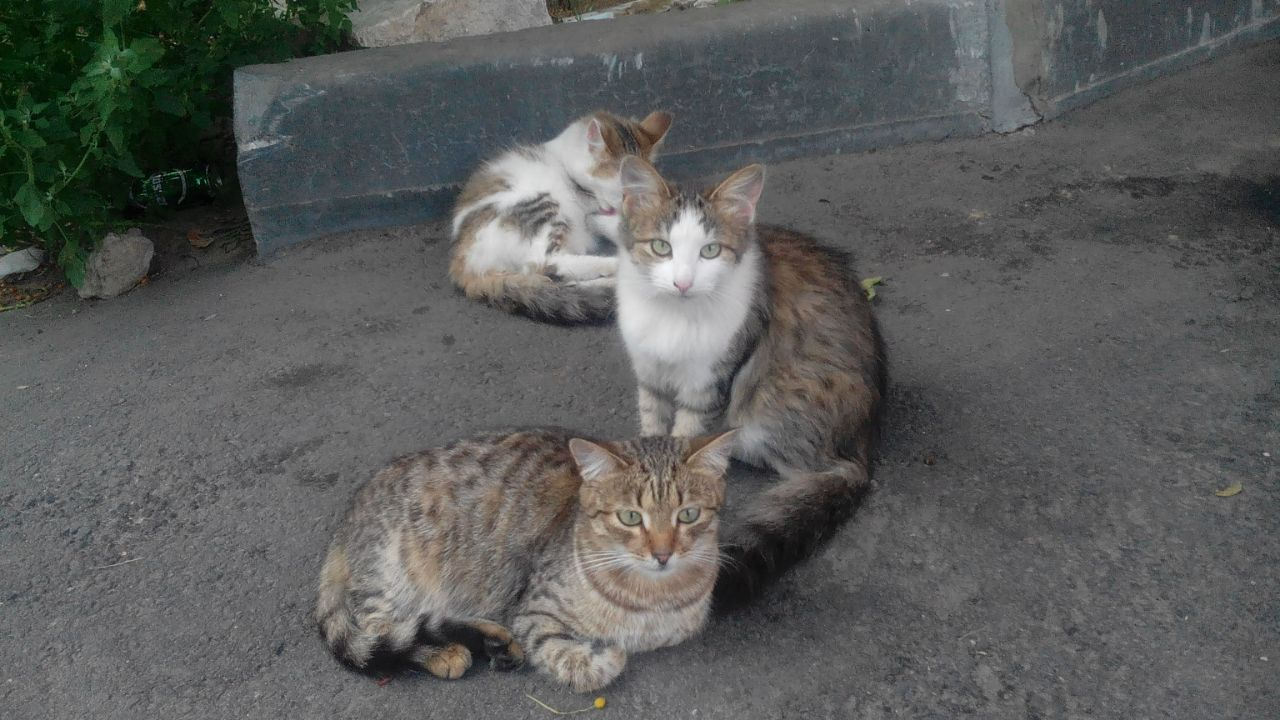

In [11]:
# Show the image in the notebok
Image(filename=IMAGE)

In [12]:
framework = 'TF'
device = 'CPU'
name = '{f} on {d}'.format(f=framework, d=device)

tensorflow_fps_collected = []

# Run inference in TensorFlow
tensorflow_predictions, tensorflow_average_inference_time = tf_main(TF_MODEL, IMAGE, number_inference=NUM_RUNS)
    
log.info('Inference Time of SSD MobileNet V2 {} is {} seconds'.format(name, tensorflow_average_inference_time))

# Calculate FPS from inference time
tensorflow_average_fps = 1 / tensorflow_average_inference_time

log.info('{} frames per second (FPS): {}'.format(name, tensorflow_average_fps))

[ INFO ] COMMON: image preprocessing
[ INFO ] Current shape: (300, 300, 3)
[ INFO ] TENSORFLOW SPECIFIC: Loading a model with TensorFlow
[ INFO ] TensorFlow graph was created
[ INFO ] Running inference with TensorFlow ...
[ INFO ] Running tf.Session
[ INFO ] TensorFlow reference collected successfully
[ INFO ] TENSORFLOW SPECIFIC: Plain inference finished
[ INFO ] Inference Time of SSD MobileNet V2 TF on CPU is 11.86044955253601 seconds
[ INFO ] TF on CPU frames per second (FPS): 0.08431383612994495


In [13]:
print(tensorflow_predictions['num_detections']) # get number of detected objects
print(tensorflow_predictions['detection_classes'][0])# get predicted classes IDs
print(tensorflow_predictions['detection_scores'][0]) # get probabilities for predicted classes
print(tensorflow_predictions['detection_boxes'][0]) # get boxes for predicted objects

[2.]
[17. 17.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[0.9847797 0.8983043 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0

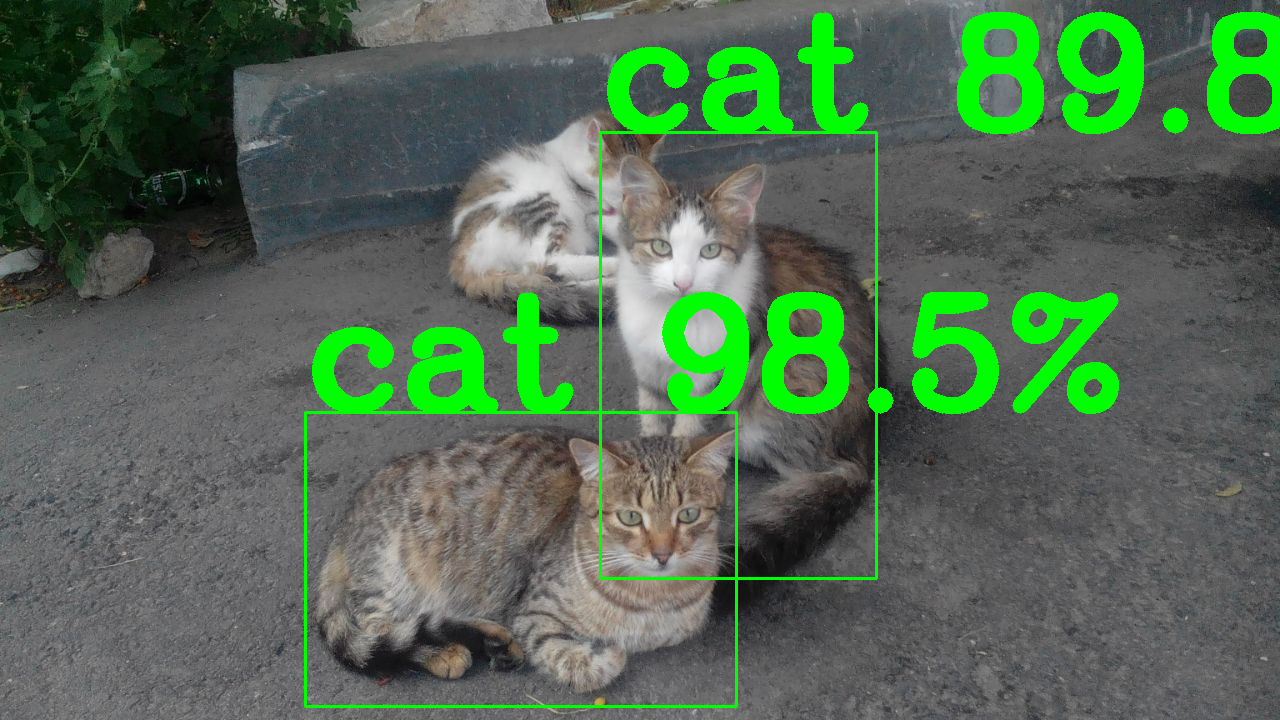

In [14]:
processd_tensorflow_predictions = parse_od_output(tensorflow_predictions)
draw_image(IMAGE, processd_tensorflow_predictions, TF_RESULT_IMAGE)

# Show the image in the notebok
Image(filename=TF_RESULT_IMAGE)

### Inference using OpenVINO

![OpenVINO inference](../images/infer.png "OpenVINO inference")

#### Step 1. Convert TF model to the IR format.

In [15]:
!python ${INTEL_OPENVINO_DIR}/deployment_tools/model_optimizer/mo.py \
--output_dir=data/public/ssd_mobilenet_v2_coco/FP32 \
--reverse_input_channels \
--model_name=ssd_mobilenet_v2_coco \
--transformations_config=${INTEL_OPENVINO_DIR}/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json \
--tensorflow_object_detection_api_pipeline_config=data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
--output=detection_classes,detection_scores,detection_boxes,num_detections \
--input_model=data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/ubuntu/notebooks/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
	- Path for generated IR: 	/home/ubuntu/notebooks/data/public/ssd_mobilenet_v2_coco/FP32
	- IR output name: 	ssd_mobilenet_v2_coco
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	detection_classes,detection_scores,detection_boxes,num_detections
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List 

### OpenVINO SSD MobileNet V2 inference 

In [16]:
def ie_inference(path_to_model_xml: str, path_to_model_bin: str, path_to_original_image: str, device='CPU', batch=1):
    """
    Entrypoint to infer with the OpenVINO inference engine
    """
    log.info('Creating inference engine core')
    ie = IECore()
    
    log.info('Reading IR ...')
    net = IENetwork(model=path_to_model_xml, weights=path_to_model_bin)
    
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    
    n, c, h, w = net.inputs[input_blob].shape
    
    log.info('Resize orginal image')
    image = read_resize_image(path_to_original_image, h, w)
    
    log.info('Loading IR to plugin')
    exec_net = ie.load_network(network=net, device_name=device)
    del net
    
    labels_map = None
    
    log.info('Preprocess image to comply with required format')
    image = image[..., ::-1]
    in_frame = image.transpose((2, 0, 1))
    batched_frame = np.array([in_frame for _ in range(batch)])
    log.info(f'Preprocessed image shape: {batched_frame.shape}')
    
    inference_start = time.time()
    res = exec_net.infer(inputs={input_blob: batched_frame})
    inference_end = time.time()
    
    log.info(f'OpenVINO inference time: {inference_end - inference_start}')
    return res[out_blob]
    

In [17]:
inference_engine_predictions = ie_inference(IE_MODEL_FP32_XML, IE_MODEL_FP32_BIN, IMAGE)

[ INFO ] Creating inference engine core
[ INFO ] Reading IR ...
[ INFO ] Resize orginal image
[ INFO ] Loading IR to plugin
[ INFO ] Preprocess image to comply with required format
[ INFO ] Preprocessed image shape: (1, 3, 300, 300)
[ INFO ] OpenVINO inference time: 0.09405088424682617


In [18]:
def draw_image(original_image: str, res: tuple, output_image: str,
              prob_threshold: float=0.8, color: tuple=(255, 0, 0)):
    """
    Takes a path to the image and bounding boxes.
    Draws those boxes on the new image and saves it.
    """
    raw_image = cv.imread(original_image)
    initial_h, initial_w, _ = raw_image.shape
    labels_map = {
        17: 'cat',
        18: 'dog',
    }
    for obj in res[0][0]:
        ignore, class_id, prob, xmin, ymin, xmax, ymax = obj  
        log.debug(f'Bound box probability: {prob}')
        if prob > prob_threshold:
            xmin = int(xmin * initial_w)
            ymin = int(ymin * initial_h)
            xmax = int(xmax * initial_w)
            ymax = int(ymax * initial_h)
            class_id = int(class_id)
            log.debug(f'Estimated class: {prob}')
            log.debug(f'x,y min: {xmin, ymin} - x,y max: {xmax, ymax}')
            confidence = round(prob * 100, 1)
            cv.rectangle(raw_image, (xmin, ymin), (xmax, ymax), color, 2)
            det_label = labels_map[class_id]
            box_title = f'{det_label} {confidence}%'
            cv.putText(raw_image, box_title, (xmin, ymin - 7), 
                       cv.FONT_HERSHEY_COMPLEX, 4, color, cv.LINE_AA)
    cv.imwrite(output_image, raw_image)
    

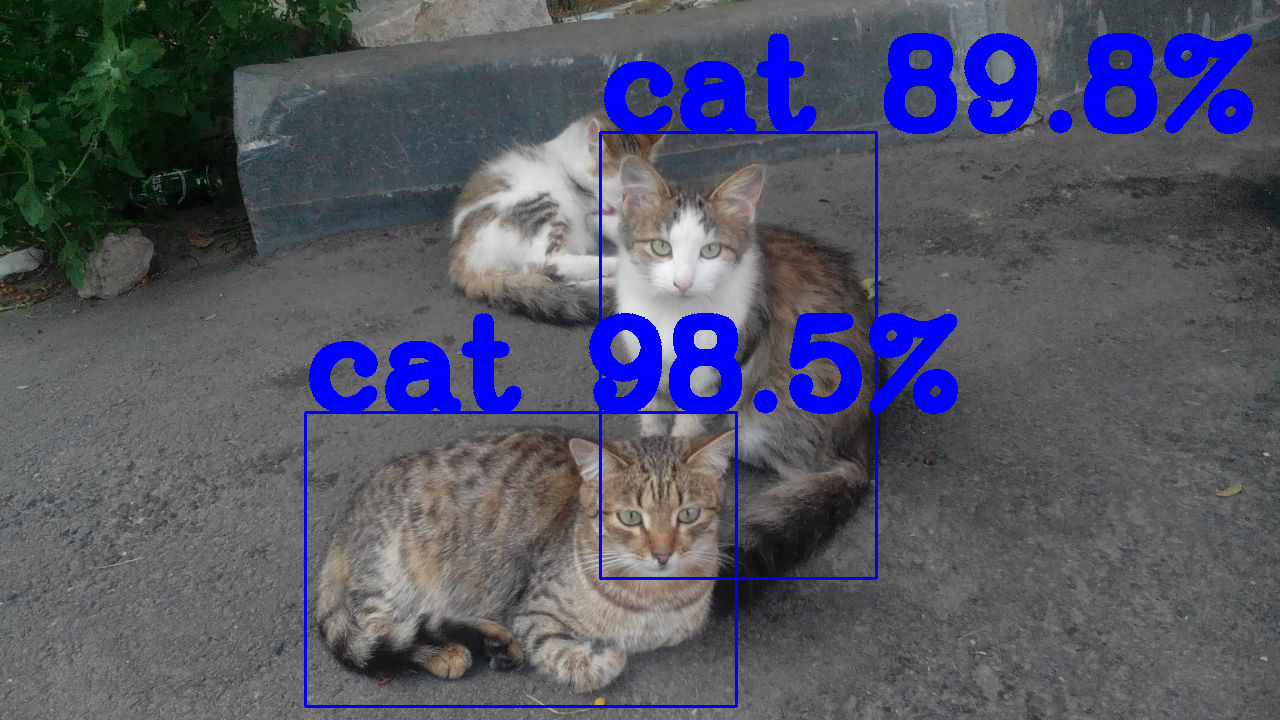

In [19]:
draw_image(IMAGE, inference_engine_predictions, IE_RESULT_IMAGE)
Image(filename=IE_RESULT_IMAGE)

### Accuracy Checker

![Accuracy Checker](../images/accuracy_check.png "Accuracy Checker")

In [20]:
# !python ${INTEL_OPENVINO_DIR}/deployment_tools/tools/post_training_optimization_toolkit/tools/evaluate.py

### Quantization

![Quantization](../images/quantization.png "Quantization")
![Quantize](../images/quantize.PNG "Quantize")

### Post-Training Optimization Toolkit

![Optimization Toolkit](../images/pot.png "Optimization Toolkit")

JSON files with all info required for calibration:

1. Model parameters (name, path to full precision IR)
2. Engine Parameters (e.g. preprocessing parameters, dataset path, etc.)
    2.1 Use accuracy checker .yml config
    2.2 Define all the required AccuracyChecker parameters directly in the JSON file
3. Compression parameters (optimization algorithm and its parameters)

DefaultQuantization algorithm performs a fast but at the same time accurate INT8 calibration of NNs. It consists of three algorithms that are sequentially applied to a model:

- ActivationChannelAlignment - Used as a preliminary step before quantization and allows you to align ranges of output activations of Convolutional layers in order to reduce the quantization error.
- MinMaxQuantization - This is a vanilla quantization method that automatically inserts FakeQuantize operations into the model graph based on the specified target hardware and initializes them using statistics collected on the calibration dataset.
- BiasCorrection - Adjusts biases of Convolutional and Fully-Connected layers based on the quantization error of the layer in order to make the overall error unbiased.

In [32]:
# !python ${INTEL_OPENVINO_DIR}/deployment_tools/tools/post_training_optimization_toolkit/main.py \
# -c data/configs/default/quantization_config.json \
# --output-dir data/public/ssd_mobilenet_v2_coco/INT8/default \
# --direct-dump

### Detecting Objects in video

In [56]:
TEST_DATA_PATH = os.path.join('.', 'data')
SSD_ASSETS = os.path.join(TEST_DATA_PATH, 'public', 'ssd_mobilenet_v2_coco')
MODEL_PATH_XML = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.xml')
MODEL_PATH_BIN = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.bin')
DEVICE = 'CPU'
VIDEO_PATH = os.path.join('data', 'video')
#INPUT_VIDEO = os.path.join(VIDEO_PATH, 'input.mp4')
INPUT_VIDEO = os.path.join(VIDEO_PATH, 'mac_n_cheese_test_video.mp4')
OUTPUT_VIDEO = os.path.join(VIDEO_PATH, 'output.mp4')
LABELS_PATH = os.path.join(VIDEO_PATH, 'coco_labels.txt')


In [57]:
HTML(f"""<video width="600" height="400" controls><source src="{INPUT_VIDEO}" type="video/mp4"></video>""")

In [58]:
def prepare_output_video_stream(input_video_stream):
    width = int(input_video_stream.get(3))
    height = int(input_video_stream.get(4))
    return cv.VideoWriter(OUTPUT_VIDEO, cv.VideoWriter_fourcc(*'X264'), 20, (width, height))

### Step 1. Instantiate the entitiy that helps us manupulate plugins using unified interfaces

In [59]:
ie = IECore()

### Step 2. Read and prepare the model

The IENetwork class is designed to work with a model in the Inference Engine. This class contains information about the network model read from the intermediate representation and allows you to manipulate some model parameters such as layers affinity and output layers.

In [60]:
net = IENetwork(MODEL_PATH_XML, MODEL_PATH_BIN)

### Step 3. Get the name of the input layer of the model

To infer a model, you need to know input layers of the model. The object ```net``` contains information about inputs of the network in a property named ```inputs``` which is a dictionary. 

- key - name of the input layer
- volume - representation of the input.

In [61]:
input_blob = next(iter(net.inputs))

print(f'Input layer of the network is {input_blob}')

Input layer of the network is image_tensor


### Step 4: Get shape (dimensions) fo the input layer of the network

- n: number of batches
- c: number of input image channels (usualy 3 for RGB)
- h: height
- w: width

In [62]:
n, c, h, w = net.inputs[input_blob].shape

print(f'Input shape of the network: [{n}, {c}, {h}, {w}]')

Input shape of the network: [1, 3, 300, 300]


### Step 5: Get names of output layers of the network

In [63]:
out_blob = next(iter(net.outputs))

print(f'Output layer of the network: {out_blob}')

Output layer of the network: DetectionOutput


Load names of COCO classes from a file

In [64]:
with open(LABELS_PATH, 'r') as f:
    labels_map = [label.strip() for label in f]
print(f'Labels: {labels_map}')    

Labels: ['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', 'b

### Step 6: Load the network to a device

- ```network```: instance of IENetwork
- ```device_name```: contains a divice name to infer a model on: CPU, GPU, FPGA, etc.


In [65]:
network_loaded_to_device = ie.load_network(network=net, device_name=DEVICE)

### Step 7: Open the input video

In [66]:
input_video_stream = cv.VideoCapture(INPUT_VIDEO)

### Step 8: Create an output video stream

In [67]:
out = prepare_output_video_stream(input_video_stream)

### Step 9: Function for processing inference results

- element 0: batch ID
- element 1: class ID
- element 2: the confidence for the object
- element 3 and 4: coordinates of the upper-left corner of the bounding box
- element 5 and 6: coordinates of the botton-right corner of the bounding box

In [68]:
from typing import Any
from typing import Dict
from typing import List

threshold = 0.0001

def draw_boxes_in_frame(obj: List[float], frame_w: int, frame_h: int, labels_map: Dict[str, str], frame: Any) -> None:
    batch_id, class_id, confidence, xmin, ymin, xmax, ymax = obj
    if confidence > threshold:
        xmin = int(xmin * frame_w)
        ymin = int(ymin * frame_h)
        xmax = int(xmax * frame_w)
        ymax = int(ymax * frame_h)
        class_id = int(class_id)
        confidence = round(confidence * 100, 1)
        log.debug(f'Estimated class: {confidence}')
        log.debug(f'x,y min: {xmin, ymin} - x,y max: {xmax, ymax}')
        color = (min(class_id * 12.5, 255), min(class_id * 7, 255), min(class_id * 5, 255))
        cv.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
        label = labels_map[class_id]
        text = f'{label}: {confidence}'
        cv.putText(frame, text, (xmin, ymin - 7), cv.FONT_HERSHEY_COMPLEX, 2, color, 2)

In [69]:
while input_video_stream.isOpened():
    ret, frame = input_video_stream.read()
    log.info(f'ret: {ret}')
    if not ret:
        break
    frame_h, frame_w = frame.shape[:2]
    log.info(f'frame_h: {frame_h}, frame_w: {frame_w}')
    in_frame = cv.resize(frame, (w, h))
    # change the data layout from HWC to CHW
    in_frame = in_frame.transpose((2, 0, 1))
    in_frame = in_frame.reshape((n, c, h, w))
    feed_dict = {
        input_blob : in_frame
    }
    
    res = network_loaded_to_device.infer(inputs=feed_dict)
    for obj in res[out_blob][0][0]:
        draw_boxes_in_frame(obj, frame_w, frame_h, labels_map, frame)
    
    out.write(frame)
out.release()    

In [70]:
from IPython.display import HTML

# Show a source video
HTML("""<video width="600" height="400" controls><source src="{}" type="video/mp4"></video>""".format(OUTPUT_VIDEO))